# Introduction

My aim in this analysis is to:
+ Provide my own estimate for when the city will run out of water.
+ Determine what a 'sustainable' dam capacity is. In other words, how high do the dams need to be going into summer *next year* to obviate our running out of water in 2019?

+ Estimate how long will it take for us to get back to that 'sustainable' dam capacity, given different scenarios of water usage and weather conditions.

In [198]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [493]:
dam_levels = pd.read_csv('data/processed/Dam-levels-clean-20120101-20171206.csv', encoding = 'latin1')
dam_levels['date'] = pd.to_datetime(dam_levels['date'])

# Add some date-related fields that will be useful later
dam_levels['year'] = dam_levels['date'].dt.year
dam_levels['month'] = dam_levels['date'].dt.month
dam_levels['monthname'] = dam_levels['date'].dt.strftime('%b')
dam_levels['dayofmonth'] = dam_levels['date'].dt.day
dam_levels['daymonthyear'] = dam_levels['dayofmonth'].apply(str) + '-' + dam_levels['monthname'] + '-' + dam_levels['year'].apply(str)

# In the plots that follow, we'll want to be smart about how we label the x-axis. Too many labels will make it 
# unreadable but having too few will make it more difficult to see what date period we're looking at. 
# Generally we'll want to plot the 1st date of every month at a particular interval. We need to calculate an 
# associated index, which will tell the plotting library where to place the labels - that's what the `dayofyear` 
# and `cumsum_dayofyear` columns are doing in the dataframe below.

first_day_of_month = dam_levels.loc[(dam_levels['dayofmonth'] == 1), ['date', 'month', 'daymonthyear']].drop_duplicates()
first_day_of_month['lag_date'] = first_day_of_month['date'].shift(periods = 1)
first_day_of_month['cumsum_dayofyear'] = (first_day_of_month['date'] - first_day_of_month['lag_date']).dt.days.cumsum().fillna(0) + 1

storage_ml_pivot = dam_levels.pivot_table(index = 'date', columns = 'dam_name', values = 'storage_ml')

agg_storage_ml = storage_ml_pivot.apply(np.sum, axis = 1)
agg_storage_ml = pd.DataFrame({'storage_ml': agg_storage_ml})
agg_storage_ml['year'] = agg_storage_ml.index.year
agg_storage_ml = agg_storage_ml.reset_index()
agg_storage_ml.index = agg_storage_ml['date']

# Work out available storage
## Work out maximum capacity
latest_dam_levels = dam_levels[dam_levels['date'] == '2017-12-06']
latest_dam_levels.index = latest_dam_levels['dam_name']
capacity = pd.DataFrame(index = latest_dam_levels['dam_name'])
capacity['max_storage_ml'] = latest_dam_levels['storage_ml']/(latest_dam_levels['current_%']/100)
## Work out 10% of capacity
capacity['unavailable_storage_ml'] = capacity['max_storage_ml'] * 0.1
## Aggregate
capacity = capacity.append(pd.Series(capacity.apply(func = sum, axis = 0), name = 'total'))

In [494]:
first_day_of_month

,date,month,daymonthyear,lag_date,cumsum_dayofyear
0,2012-01-01,1,1-Jan-2012,NaT,1.0
31,2012-02-01,2,1-Feb-2012,2012-01-01,32.0
60,2012-03-01,3,1-Mar-2012,2012-02-01,61.0
91,2012-04-01,4,1-Apr-2012,2012-03-01,92.0
121,2012-05-01,5,1-May-2012,2012-04-01,122.0
152,2012-06-01,6,1-Jun-2012,2012-05-01,153.0
182,2012-07-01,7,1-Jul-2012,2012-06-01,183.0
213,2012-08-01,8,1-Aug-2012,2012-07-01,214.0
244,2012-09-01,9,1-Sep-2012,2012-08-01,245.0
274,2012-10-01,10,1-Oct-2012,2012-09-01,275.0


In [498]:
first_day_of_quarter

,date,month,daymonthyear,lag_date,cumsum_dayofyear
366,2013-01-01,1,1-Jan-2013,2012-12-01,367.0
456,2013-04-01,4,1-Apr-2013,2013-03-01,457.0
547,2013-07-01,7,1-Jul-2013,2013-06-01,548.0
639,2013-10-01,10,1-Oct-2013,2013-09-01,640.0


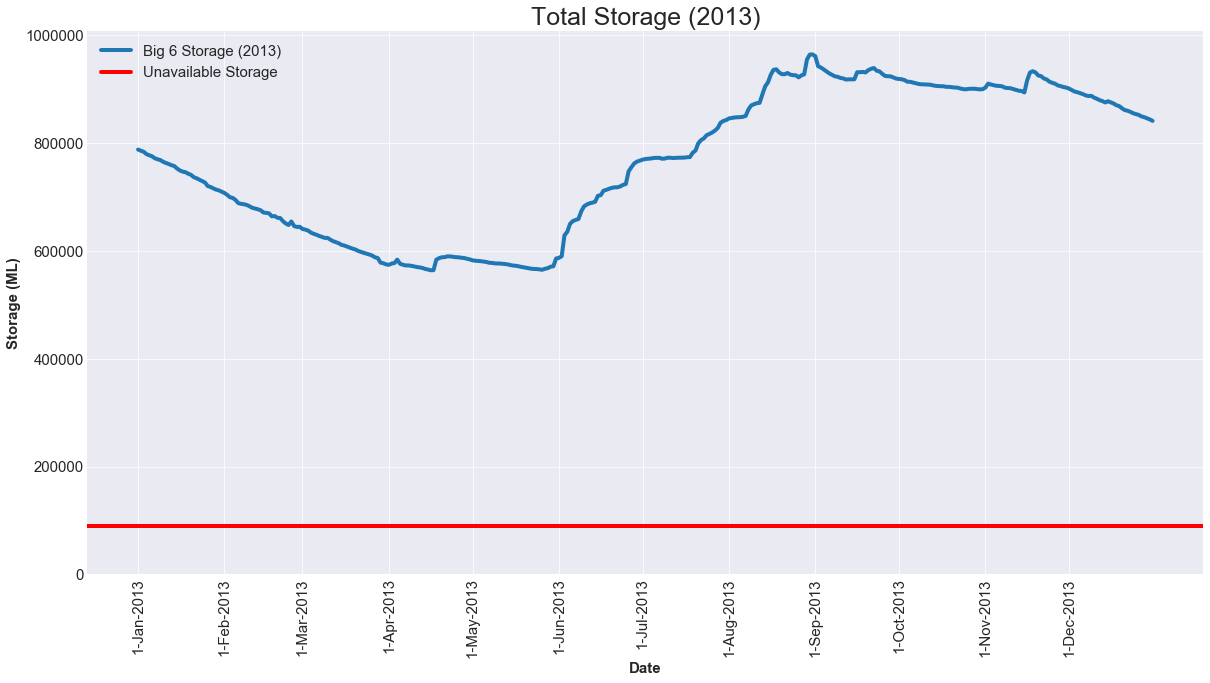

In [503]:
# Sets style for pyplot graphs to match seaborn
sns.set_style("darkgrid")

df = agg_storage_ml.loc[agg_storage_ml['year'] == 2013]

fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
plt.plot(range(len(df)),
         df['storage_ml'], 
         label = 'Big 6 Storage (2013)', 
         linewidth = 4)
ax.axhline(y = capacity.loc['total']['unavailable_storage_ml'], 
           label = 'Unavailable Storage', 
           c = 'red', 
           linewidth = 4)

fd = first_day_of_month.loc[first_day_of_month['date'].dt.year == 2013]

plt.xticks(fd['cumsum_dayofyear'] - 367.0, fd['daymonthyear'], rotation = 90, fontsize = 15);
plt.xlabel('Date', fontsize = 15, fontweight = 'bold')

plt.yticks(fontsize = 15)
plt.ylabel('Storage (ML)', fontsize = 15, fontweight = 'bold')
plt.ylim(ymin = 0)

plt.legend(fontsize = 15)
plt.title('Total Storage (2013)', fontsize = 25);

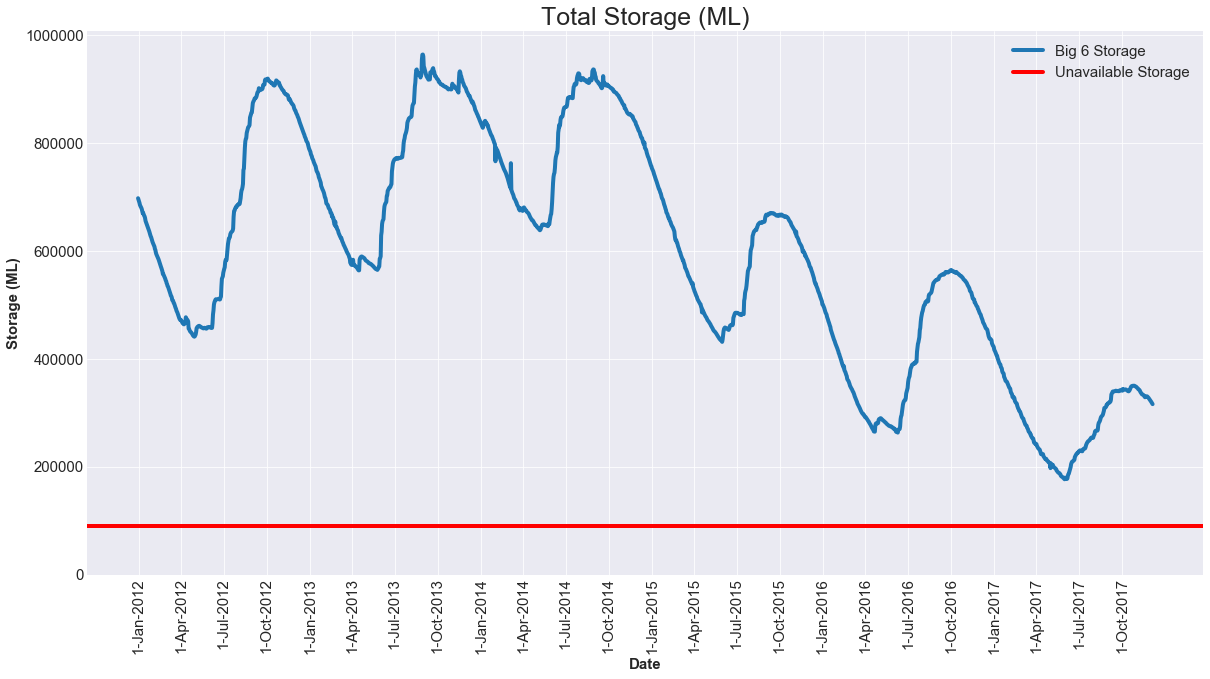

In [200]:
# Sets style for pyplot graphs to match seaborn
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
plt.plot(range(len(agg_storage_ml)),
         agg_storage_ml['storage_ml'], 
         label = 'Big 6 Storage', 
         linewidth = 4)
ax.axhline(y = capacity.loc['total']['unavailable_storage_ml'], 
           label = 'Unavailable Storage', 
           c = 'red', 
           linewidth = 4)

first_day_of_quarter = first_day_of_month[first_day_of_month['month'].isin([1, 4, 7, 10])]

plt.xticks(first_day_of_quarter['cumsum_dayofyear'], first_day_of_quarter['daymonthyear'], rotation = 90, fontsize = 15);
plt.xlabel('Date', fontsize = 15, fontweight = 'bold')

plt.yticks(fontsize = 15)
plt.ylabel('Storage (ML)', fontsize = 15, fontweight = 'bold')
plt.ylim(ymin = 0)

plt.legend(fontsize = 15)
plt.title('Total Storage (ML)', fontsize = 25);

# When will we run out of water?

There have been estimates for when the city will run out of water - notably from the [CSAG](http://www.csag.uct.ac.za/2017/10/24/waiting-for-the-rain/) and [this](http://www.howmanydaysofwaterdoescapetownhaveleft.co.za/) website. While the latter doesn't disclose how they arrived at their number, the former, written by [Piotr Wolski](http://www.csag.uct.ac.za/author/pwolski/) does. My approach will follow his logic. My contribution here will be in providing an updated figure, based on current dam levels and usage stats.

Let's assume that there are no meaningful inflows of water into the dams during the summer period. Then we can work out the number of days of water we have left with this simple formula:
$$d = {s \over c}$$

where:
+ d = number of days remaining
+ s = current volume of water storaged in the dams
+ c = average daily water consumption

The City of Cape Town (CoCT) published a ("water dashboard"](https://resource.capetown.gov.za/documentcentre/Documents/City%20research%20reports%20and%20review/damlevels.pdf), which states that the total volume of dammed water is 282,417Ml. However, the last 10% of the water is unusable, since it become impossible to extract. The total capacity is 902,598Ml, which means that we need to subtract 90,259.8Ml, which leaves us 192,157Ml remaining. 

The same source shows daily consumption by the City at 561Ml (Ml = "megalitres") per day. So we almost have everything we need to plug in to the above formula and solve for the days. However, we only have the *City's* consumption. According to the Water & Sanitation Department, CoCT's share of total water consumption is only 40%. This is illustrated in the chart below, which can be found [here](https://www.groundup.org.za/media/uploads/documents/BusinessBriefingOnWaterCrisis9MayPeterFlowerPresentationHandout.pdf):

<img src= resources/waterusewcwss.png style="width: 350px;"/>

So if we want to get the *total* water consumption, we need to scale up the the consumption by a factor of 100/40 = 2.5. This means that total consumtpion is 1402.5Ml per day. This means that we have 192,157/1,402.5 = 137 days left. This puts 'day zero' at 19 May 2018.

In [201]:
# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import datetime
(datetime.date.today() + datetime.timedelta(days = 137)).strftime('%Y-%m-%d')

'2018-05-22'

The table below shows the same for different consumption levels:

# How much water do we need going in to summer?

How much water do we need in the dams at the beginning of summer to last us through the season, until the winter rains come? This depends on how much water we use. I will attempt to answer this question given historical, current, and target water usage levels.

If we again assume that there will be no meaningful inflows of water into the dam, we can can just rearrange the equation above and solve for *s* - the total storage needed is the sum of all the water consumed each day: 
$$s = d \times c$$

The water consumption per day is a parameter that we don't need to calculate. Eyeballing dam storage graph above, we can see that dam levels drop off from between the beginning of October and the latter half of June. Let's be conservative here, and assume that the dry season ends on the 15th of June. That gives us 287 days. This leaves only 20% of the year to for water levels to recover.

In [202]:
dry_season_end_date = datetime.datetime(year = 2019, month = 6, day = 15)
dry_season_start_date = datetime.datetime(year = 2018, month = 9, day = 1)
print('Days in the dry season:', (dry_season_end_date - dry_season_start_date).days)
print('Percent of days in the year that are within the dry season: ', ('{:.0%}').format(287/365))

Days in the dry season: 287
Percent of days in the year that are within the dry season:  79%


Plugging in to our equation above, we get s = 287 * 1,402.5 = 402,517.5. We can do the same for different consumption levels.

In [203]:
import pandas as pd
storage_needed = pd.DataFrame()
storage_needed['CoCT Avg Daily Consumption'] = [500, 561, 600]
storage_needed['Total Avg Daily Consumption'] = 2.5 * storage_needed['CoCT Avg Daily Consumption']
storage_needed['Storage Needed'] = 287 * storage_needed['Total Avg Daily Consumption']
storage_needed.style.format('{:,.0f}')

,CoCT Avg Daily Consumption,Total Avg Daily Consumption,Storage Needed
0,500,"1,250","358,750"
1,561,"1,402","402,518"
2,600,"1,500","430,500"


# How long will it take for dam levels to reach sustainable levels?

So far, we have been working with the dry period and have not been worrying about inflows of water into the dams. However, the wet season brings rains, which will cause dam levels to increase. Generally, there are enough rains each year that we don't need to worry about running out by the end of the proceeding dry season. However, that is not a given. If we assume that we have no water left by the end of the current dry season, how long will it take to get back to a sustainable levels? 

I will assume that the daily average consumption remaines 561Ml so that a sustainable level is 402,518Ml. If we have usable water left by the end of summer this year, how long will it take us to get back to that level? There are different ways to model the dams but let's keep it simple for now and use a straight line. Taking the dam levels for the beginngina nd end of the rainy season each year, we can figure out the gradient of the line for each year. I will work out how long it will take, given 3 scenarios: (1) best case: using the steepest gradient, (2) average: using the average gradient, and (3) worst case: using the most lowest gradient.

To be conservative, I'm going to assume that the beginning of the wet season is the day after the the minimum dam level is reached for the year and the end of the wet season is the day the maximum dam storage is reached.



In [522]:
# min_storage = agg_storage_ml.loc[agg_storage_ml.loc[(agg_storage_ml['date'].dt.month == 6) &
#                                                     (agg_storage_ml['date'].dt.day == 1)].index, ['year', 'storage_ml']]
min_storage = agg_storage_ml.loc[agg_storage_ml.groupby('year')['storage_ml'].idxmin(), ['year', 'storage_ml']]
min_storage = min_storage.reset_index()[['year', 'date', 'storage_ml']]
min_storage = min_storage.rename(columns = {'date': 'start_date',
                                           'storage_ml': 'start_storage_ml'})

max_storage = pd.merge(agg_storage_ml, min_storage, on = ['year'])
max_storage.index = max_storage['date']
max_storage = max_storage.loc[max_storage['date'] > max_storage['start_date']]

max_storage = max_storage.loc[max_storage.groupby('year')['storage_ml'].idxmax(), ['year', 'storage_ml']]
max_storage = max_storage.reset_index()[['year', 'date', 'storage_ml']]
max_storage = max_storage.rename(columns = {'date': 'end_date',
                                           'storage_ml': 'end_storage_ml'})

wet_season = pd.merge(min_storage, max_storage, on = ['year'], copy = False)
wet_season = wet_season.rename(columns = {'date': 'start_date'})
wet_season['season_length'] = wet_season['end_date'] - wet_season['start_date']

In [523]:
# CHECK date start and end (start date should be day after min)

wet_season_storage = pd.merge(agg_storage_ml, wet_season, on = ['year'])
wet_season_storage = wet_season_storage[(wet_season_storage['date'] >= wet_season_storage['start_date']) &
                       (wet_season_storage['date'] <= wet_season_storage['end_date'])]

In [524]:
wet_season_storage.loc[wet_season_storage['year'] == 2013].head()

,date,storage_ml,year,start_date,start_storage_ml,end_date,end_storage_ml,season_length
471,2013-04-16,564195.0,2013,2013-04-16,564195.0,2013-08-31,964590.3,137 days
472,2013-04-17,564309.5,2013,2013-04-16,564195.0,2013-08-31,964590.3,137 days
473,2013-04-18,583786.8,2013,2013-04-16,564195.0,2013-08-31,964590.3,137 days
474,2013-04-19,586599.3,2013,2013-04-16,564195.0,2013-08-31,964590.3,137 days
475,2013-04-20,588288.7,2013,2013-04-16,564195.0,2013-08-31,964590.3,137 days


## Fit curves for 2012-2017 combined

In [551]:
flat_wet_seasons.head()

,dates,season_day,storage_ml
121,2012-05-01,0,0.0
122,2012-05-02,1,1869.2
123,2012-05-03,2,3835.0
124,2012-05-04,3,8478.8
125,2012-05-05,4,15317.7


In [654]:
import matplotlib.dates as mdates
# x = range(len(wet_season_storage.loc[wet_season_storage['year'] == y, 'date']))

aligned_wet_seasons = {}
flat_wet_seasons = pd.DataFrame()
for y in list(range(2012,2018)):
    season = pd.DataFrame()
    season['date'] = wet_season_storage.loc[wet_season_storage['year'] == y, 'date']
    season['season_day'] = list(range(len(season['date'])))
    season['storage_ml'] = (wet_season_storage.loc[wet_season_storage['year'] == y, 'storage_ml'] - wet_season_storage.loc[wet_season_storage['year'] == y, 'start_storage_ml']).tolist()
    aligned_wet_seasons[y] = season
    flat_wet_seasons = pd.concat([flat_wet_seasons, season], axis = 0)
    
f = np.polyfit(flat_wet_seasons['season_day'], flat_wet_seasons['storage_ml'], deg = 3)
all_fit = np.poly1d(f)

flat_wet_seasons_good = flat_wet_seasons[flat_wet_seasons['date'].dt.year.isin([2012, 2013])]
f = np.polyfit(flat_wet_seasons_good['season_day'], flat_wet_seasons_good['storage_ml'], deg = 3)
good_season_fit = np.poly1d(f)

flat_wet_seasons_bad = flat_wet_seasons[flat_wet_seasons['date'].dt.year.isin([2014, 2015, 2016])]
f = np.polyfit(flat_wet_seasons_bad['season_day'], flat_wet_seasons_bad['storage_ml'], deg = 3)
bad_season_fit = np.poly1d(f)

flat_wet_seasons_worst = flat_wet_seasons[flat_wet_seasons['date'].dt.year.isin([2017])]
f = np.polyfit(flat_wet_seasons_worst['season_day'], flat_wet_seasons_worst['storage_ml'], deg = 3)
worst_season_fit = np.poly1d(f)

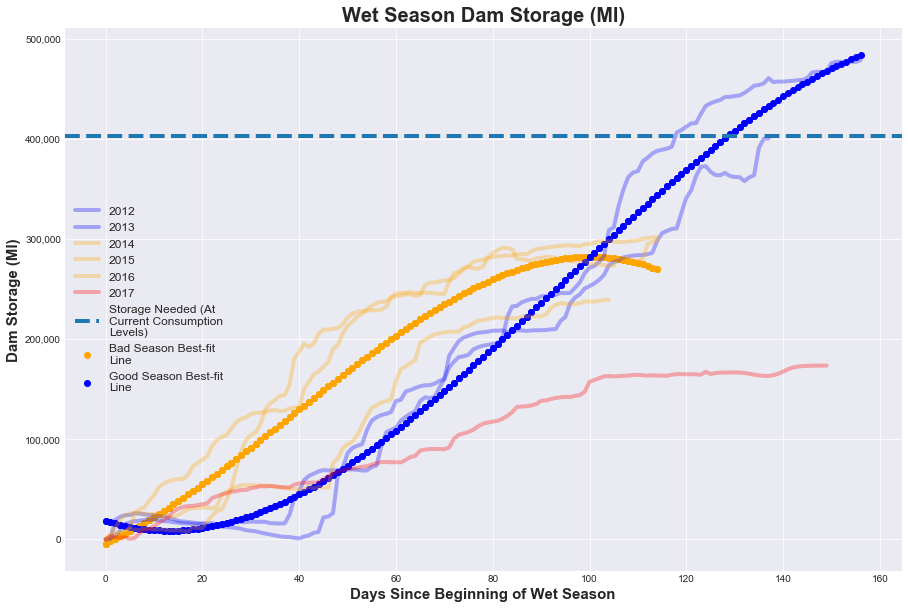

In [657]:
from textwrap import wrap

fig, ax = plt.subplots(figsize=(15,10))
colours = [
    'blue',
    'blue',
    'orange',
    'orange',
    'orange',
    'red',
]

y = list(range(2012,2018))
# y = [2012,2013,2015,2016]
for i, y in enumerate(y):
    plt.plot(aligned_wet_seasons[y]['season_day'], aligned_wet_seasons[y]['storage_ml'], label = y, 
             c = colours[i], linewidth = 4, alpha = 0.3)
ax.axhline(402518, linewidth = 4, label = 'Storage Needed (At Current Consumption Levels)', linestyle = '--')
# plt.scatter(flat_wet_seasons['season_day'], all_fit(flat_wet_seasons['season_day']), 
#             c = 'green', label = 'Total Best-fit Line')
plt.scatter(flat_wet_seasons_bad['season_day'], bad_season_fit(flat_wet_seasons_bad['season_day']), 
            c = 'orange', label = 'Bad Season Best-fit Line')
# plt.scatter(flat_wet_seasons_worst['season_day'], worst_season_fit(flat_wet_seasons_worst['season_day']), 
#             c = 'red', label = 'Worst Season Best-fit Line')
plt.scatter(flat_wet_seasons_good['season_day'], good_season_fit(flat_wet_seasons_good['season_day']), 
            c = 'blue', label = 'Good Season Best-fit Line')

plt.title('Wet Season Dam Storage (Ml)', fontsize = 20, fontweight = 'bold')
plt.xlabel('Days Since Beginning of Wet Season', fontsize = 15, fontweight = 'bold', )
plt.ylabel('Dam Storage (Ml)', fontsize = 15, fontweight = 'bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

handles, labels = ax.get_legend_handles_labels()
labels = [ '\n'.join(wrap(lab, 20)) for lab in labels]
ax.legend(labels, fontsize = 12)

plt.show();

## Fit curves for individual years

In [288]:
import matplotlib.dates as mdates
fits = {}
for y in wet_season_storage['year'].unique():
    x = range(len(wet_season_storage.loc[wet_season_storage['year'] == y, 'date']))
    #x = mdates.date2num(wet_season_storage.loc[wet_season_storage['year'] == y, 'date'].astype(datetime.date))
    f = np.polyfit(x, wet_season_storage.loc[wet_season_storage['year'] == y, 'storage_ml'], deg = 2)
    fits[y] = (x, np.poly1d(f))

2016

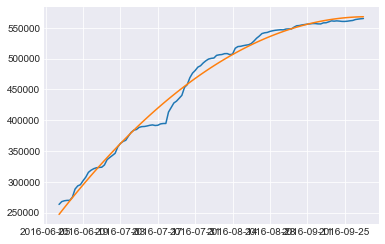

2017

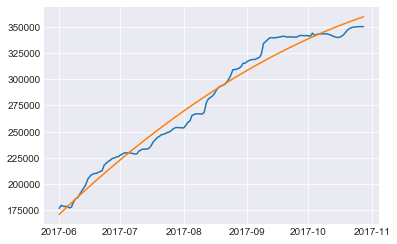

2012

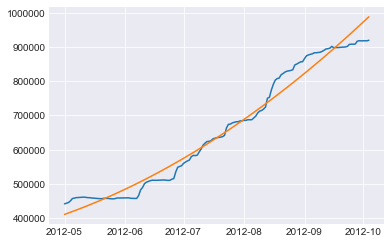

2013

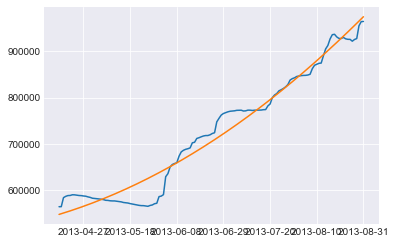

2014

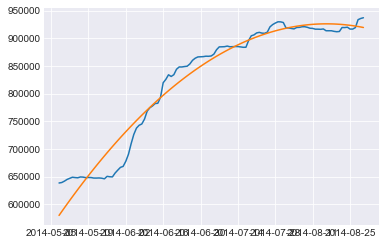

2015

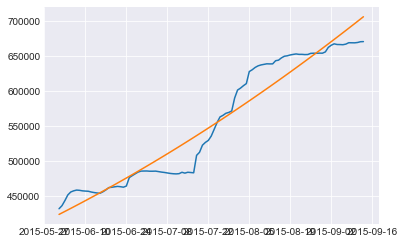

In [289]:
for y, f in fits.items():
    y
    plt.plot(wet_season_storage.loc[wet_season_storage['year'] == y, 'date'], wet_season_storage.loc[wet_season_storage['year'] == y, 'storage_ml'])
    plt.plot(wet_season_storage.loc[wet_season_storage['year'] == y, 'date'], f[1](f[0]))
    plt.show();

In [374]:
import math
for y, f in fits.items():
#     print('{0}: {1} days'.format(y, 402518/f[1][1]))
    start_storage = wet_season.loc[wet_season['year'] == y, 'start_storage_ml']
    fit = f[1]
    c = fit[0] - start_storage - 402518
    b = fit[1]
    a = fit[2]
    try:
        days0 = float(-(b - math.sqrt(math.pow(b, 2) - 4*a*c))/(2*a))
    except ValueError:
        print('!',str(y),1)
    try:
        days1 = float(-(b + math.sqrt(math.pow(b, 2) - 4*a*c))/(2*a))
    except ValueError:
        print('!',str(y),2)
    
    print('{0}: {1}d or {2}d days'.format(y, days0, days1))
    print()

2012: 127.46389265543789d or -318.0914960778423d days

2013: 135.29884041816004d or -255.96015019341044d days

! 2014 1
! 2014 2
2014: 135.29884041816004d or -255.96015019341044d days

2015: 140.3894974715913d or -520.468847724122d days

! 2016 1
! 2016 2
2016: 140.3894974715913d or -520.468847724122d days

! 2017 1
! 2017 2
2017: 140.3894974715913d or -520.468847724122d days



In [339]:
np.sqrt(4)

2.0

# What dam storage is sustainable at the beginning of summer?
By *sustainable* dam storage, I mean that we have enough water to last us, not only through the impending summer season, but, in combination with water production in winter, the *following* season. By *water production*, I mean addional water storage added to the dams - whether by precipitation or other means, such as desalination. Why could this be different from the question that I answered above, regarding how much water we need going in to summer? If the net water production (water production less water usage) during the winter season does not at least equal the amount we use during summer, then we need some water left in the dam after summer is over to make the difference.    

This will depend on water usage throughout winter, as well as water production throughout the period.

# Conclusion

In [336]:
wet_season_storage['month'] = wet_season_storage['date'].dt.month
wet_season_storage['dayofmonth'] = wet_season_storage['date'].dt.day
wet_season_storage['daymonthyear'] = wet_season_storage.apply(lambda r: datetime.date(day = pd.to_numeric(r['dayofmonth']),
                                                                                  month = pd.to_numeric(r['month']),
                                                                                  year = 2017), 
                                                          axis = 1)


In [284]:
first_day_of_month = wet_season_storage.loc[(wet_season_storage['dayofmonth'] == 1), ['date', 'daymonthyear']].drop_duplicates()
first_day_of_month['lag_date'] = first_day_of_month['date'].shift(periods = 1)
first_day_of_month['cumsum_dayofyear'] = (first_day_of_month['date'] - first_day_of_month['lag_date']).dt.days.cumsum().fillna(0) + 1


In [278]:
ddates = mdates.num2date(dates)
ddates = [d.date() for d in ddates]